In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib               import pyplot as plt
from sklearn.decomposition    import PCA
from mlxtend.plotting         import plot_decision_regions
from tabulate                 import tabulate

from sklearn.preprocessing    import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection  import train_test_split
from sklearn                  import linear_model
from sklearn                  import metrics
from sklearn.metrics          import classification_report # Produces nice report on classification
from sklearn.metrics          import confusion_matrix      # Returns the confusion matrix

from sklearn                  import svm
from sklearn.linear_model     import LinearRegression      # Linear Regression Class
from sklearn.linear_model     import LogisticRegression    # Logistic Regression Class
from sklearn.svm              import SVC                   # SVM Regression Class
from sklearn.svm              import SVR                   # SVM Regression Class
from sklearn.ensemble         import RandomForestRegressor
from sklearn.ensemble         import GradientBoostingRegressor
from sklearn.model_selection  import GridSearchCV

from sklearn.neighbors        import KNeighborsClassifier  # k-Nearest Neighbors Classification Class
from sklearn.neural_network   import MLPClassifier

%matplotlib inline

## Περιγραφή και εκκαθάριση δεδομένων
<br>Η εργασία βασίζεται σε δεδομένα δημοπρασιών της μορφής που διεξάγονται στο ebay. Οι μεταβλητές που περιλαμβάνονται στο αρχείο παρουσιάζονται παρακάτω. <br> 
Αρχικά, πραγματοποιείται έλεγχος των δεδομένων κατά τον οποίο δεν εμφανίζονται κενές τιμές στο dataset. Παρ΄ όλα αυτά παρουσιάζονται κενά στους τίτλους των στηλών τα οποία αφαιρούνται.

In [4]:
df = pd.read_csv("auction_data.csv")
df.columns = df.columns.str.replace(' ', '')
df

,SellerId,SellerRating,ItemId,StartingBid,Price,NumBidders
0,144.0,84.11,6.0,137.0,145.5,2.0
1,40.0,93.76,0.0,30.0,30.0,0.0
2,102.0,94.52,12.0,364.0,1278.0,8.0
3,77.0,97.41,2.0,82.0,106.5,3.0
4,54.0,80.32,4.0,173.0,173.0,0.0
...,...,...,...,...,...,...
18837,40.0,93.76,2.0,72.0,92.0,3.0
18838,112.0,84.30,3.0,100.0,139.5,3.0
18839,116.0,99.26,8.0,243.0,498.0,5.0
18840,10.0,87.26,4.0,167.0,169.5,1.0


In [5]:
list(df.columns)

['SellerId', 'SellerRating', 'ItemId', 'StartingBid', 'Price', 'NumBidders']

In [6]:
df.isnull().any()

SellerId        False
SellerRating    False
ItemId          False
StartingBid     False
Price           False
NumBidders      False
dtype: bool

Από τις μεταβλητές του dataset αυτές του <b>SellerID</b> καθώς και <b>ItemID</b> είναι αδιάφορες ως προς την πρόβλεψη των τιμών κλεισίματος, του κέρδους αλλά και της ανάδειξη της δημοπρασίας ως ολοκληρωμένη ( πραγματοποίηση πώλησης) και ως εκ τούτου αφαιρούνται.<br><br>
Τέλος, προστίθεται μια νέα στήλη η οποία αναφέρει εάν η δημοπρασία έχει καταλήξει σε πώληση ή όχι. Η νέα στήλη δημιουργείται από τον έλεγχο της Τιμής Εκκίνησης και της Τιμής Κλεισίματος


In [7]:
#add 'Sold' column where 0=not sold (aka StartingBid has the same value as Price) and 1=sold
df['Sold'] = np.where(df['StartingBid']==df['Price'], '0', '1')

#remove irrelevant columns 
cols_to_drop = ["SellerId","ItemId"]
df = df.drop(columns=cols_to_drop,axis=1)
df.head(10)

,SellerRating,StartingBid,Price,NumBidders,Sold
0,84.11,137.0,145.5,2.0,1
1,93.76,30.0,30.0,0.0,0
2,94.52,364.0,1278.0,8.0,1
3,97.41,82.0,106.5,3.0,1
4,80.32,173.0,173.0,0.0,0
5,99.97,836.0,1146.0,4.0,1
6,99.01,207.0,599.0,4.0,1
7,99.97,348.0,529.0,3.0,1
8,99.26,18.0,100.0,7.0,1
9,84.11,8.0,24.5,4.0,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18842 entries, 0 to 18841
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SellerRating  18842 non-null  float64
 1   StartingBid   18842 non-null  float64
 2   Price         18842 non-null  float64
 3   NumBidders    18842 non-null  float64
 4   Sold          18842 non-null  object 
dtypes: float64(4), object(1)
memory usage: 736.1+ KB


In [9]:
df.describe()

,SellerRating,StartingBid,Price,NumBidders
count,18842.000000,18842.000000,18842.000000,18842.000000
mean,90.046164,316.835899,393.979753,2.242172
std,6.009262,350.345270,384.044470,2.016307
min,80.050000,1.000000,1.250000,0.000000
25%,84.820000,80.000000,135.500000,0.000000
50%,90.460000,181.000000,235.500000,2.000000
75%,94.990000,426.000000,568.000000,4.000000
max,99.980000,2299.000000,2299.000000,10.000000


Παρακάτω παρουσιάζεται η συσχέτιση μεταξύ των μεταβλητών. Όπως παρατηρείται οι τιμές StartingBid και Price έχουν αρκετή συσχέτιση όπως ήταν αναμενόμενο.

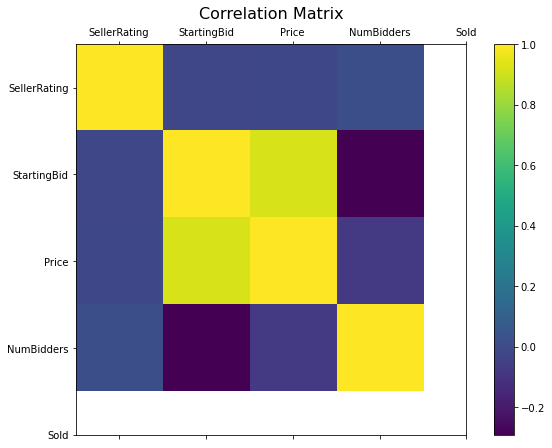

In [10]:
f = plt.figure(figsize = (10,7))
plt.matshow(df.corr(), fignum = f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=10, rotation=0)
plt.yticks(range(df.shape[1]), df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=16);

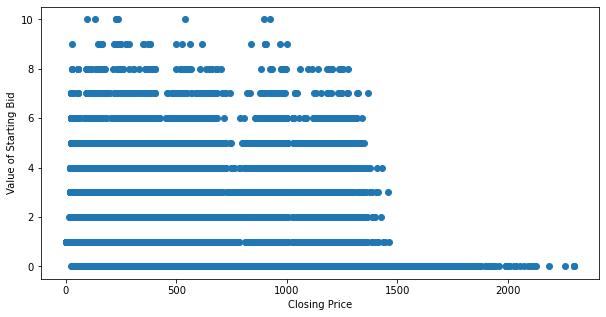

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df['Price'], df['NumBidders'])
ax.set_xlabel('Closing Price')
ax.set_ylabel('Value of Starting Bid')
plt.show()

Στο παραπάνω διάγραμμα παρατηρούνται κάποιοι outliers οι οποίοι απομονώνονται με τη χρήση IQR.
Παρ' όλα αυτά οι τιμές αυτές θεωρούνται χρήσιμες οπότε δεν αφαιρούνται από το dataset

In [12]:
# outlier detection and removal
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1 
filter = (df['Price'] >= Q1 - 1.5 * IQR) & (df['Price'] <= Q3 + 1.5 *IQR)
df2 = df.loc[filter]
df2

,SellerRating,StartingBid,Price,NumBidders,Sold
0,84.11,137.0,145.5,2.0,1
1,93.76,30.0,30.0,0.0,0
3,97.41,82.0,106.5,3.0,1
4,80.32,173.0,173.0,0.0,0
5,99.97,836.0,1146.0,4.0,1
...,...,...,...,...,...
18837,93.76,72.0,92.0,3.0,1
18838,84.30,100.0,139.5,3.0,1
18839,99.26,243.0,498.0,5.0,1
18840,87.26,167.0,169.5,1.0,1


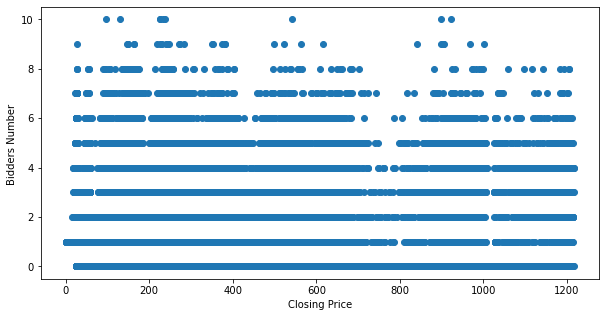

In [13]:
#visualize the dataset without the outliers
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df2['Price'], df2['NumBidders'])
ax.set_xlabel('Closing Price')
ax.set_ylabel('Bidders Number ')
plt.show()

## 1. Πρόβλεψη Τιμής Κλεισίματος<br>

Για την πρόβλεψη της τιμής κλεισίματος γίνεται χρήση του μοντέλου Multiple Regression και Random Forest.<br> 
Αρχικά το dataset χωρίζεται σε 70% train και 30% test με εξαρτημένη μεταβλητή το Price.<br>


### 1.1 Multiple Regression<br>

In [14]:
#define x and y variables
#split the dataset in 70% train and 30% test

y = df.Price
X = df[['SellerRating', 'StartingBid', 'NumBidders', 'Sold']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42) 
X_test

,SellerRating,StartingBid,NumBidders,Sold
10071,87.26,159.0,1.0,1
13354,86.84,715.0,4.0,1
11650,86.75,70.0,0.0,0
1383,99.26,53.0,5.0,1
4771,80.31,32.0,4.0,1
...,...,...,...,...
6181,90.57,24.0,2.0,1
4044,91.90,277.0,0.0,0
10529,80.18,17.0,3.0,1
14107,94.26,14.0,4.0,1


In [15]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(13189, 4) (13189,)
(5653, 4) (5653,)


In [16]:
# sc_x = StandardScaler()
# X_train = sc_x.fit_transform(X_train)
# X_test = sc_x.fit_transform(X_test)

Παρατηρήθηκε πως μετά την κανονικοποίηση των δεδομένων παρ' όλο που το accuracy δεν παρουσιάζει μεγάλη διαφορά οι τιμές των Coefficient μεταβάλλονται αρκετά. <br> Συγκεκριμένα παράγονται τα παρακάτω αποτελέσματα:

**Coefficient**<br>
SellerRating:	-0.309745<br>
StartingBid:	381.599133<br>
NumBidders:	87.062954<br>
Sold:	-4.325168<br>

Στον παραπάνω πίνακα η μεταβλητή Price διαθέτει την μεγαλύτερη εξάρτηση με την μεταβλητή StartingBid και στη συνέχεια με την NumBidders, κάτι το οποίο δεν ισχύει. Συνεπώς δεν θα γίνει κανονικοποίηση στα δεδομένα.<br>
Σε αυτή την περίπτωση όπως φαίνεται παρακάτω τον μεγαλύτερο συντελεστή coeffiency διαθέτει το NumBidders 

In [17]:
linear = LinearRegression() 

In [18]:
linear.fit(X_train, y_train) 
print('Coefficients:', linear.coef_)
print('Intercept:', linear.intercept_)

Coefficients: [-0.05142089  1.08143884 43.26921197 -9.43944952]
Intercept: -33.46612452230835


In [19]:
coeff_df = pd.DataFrame(linear.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
SellerRating,-0.051421
StartingBid,1.081439
NumBidders,43.269212
Sold,-9.439450


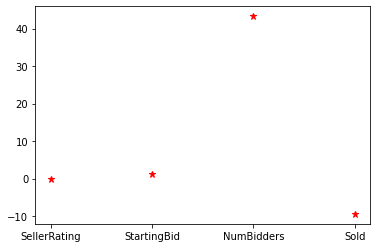

In [20]:
plt.plot(coeff_df, linestyle = 'none', marker = '*', markersize = 7, color = 'red', zorder = 7)

Παρακάτω απεικονίζονται συγκριτικοι πίνακες και διαγράμματα των πραγματικών και την προβλεπόμενων τιμών.

In [21]:
y_pred = linear.predict(X_test)
df_new = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_new

,Actual,Predicted
10071,161.5,167.825427
13354,998.0,898.934654
11650,70.0,37.773832
1383,173.5,225.652707
4771,52.0,160.647705
...,...,...
6181,26.0,64.930192
4044,277.0,261.366854
10529,24.5,101.163595
14107,23.5,140.464484


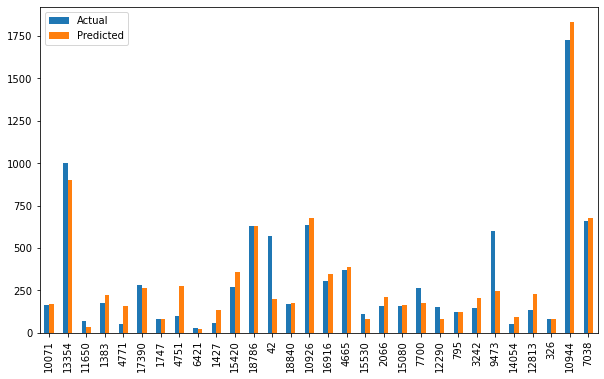

In [22]:
#visualize the difference between actual price and predicted price
AvsP = df_new.head(30)
AvsP.plot(kind ='bar',figsize = (10,6))
plt.show()

In [23]:
print('Accuracy:',linear.score(X_test,y_test))

Accuracy: 0.895533787589926


In [24]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 68.87593182097979
Mean Squared Error: 14804.330600460356
Root Mean Squared Error: 121.67304796239945


### 1.2 Random Forest
Στη συνέχεια γίνεται εκπαίδευση του dataset χρησιμοποιώντας Random Forest Regressor.<br>
Για την εύρεση του optimal n_estimaros γίνεται χρήση της παραμέτρου GridSearchCV για 10, 100, 1000 δέντρα. Βάση των αποτελεσμάτων η εκπαίδευση γίνεται με n_estimators = 1000 και καταλήγει σε accuracy 89,6%.

In [27]:
y= df.Price
X= df[['SellerRating', 'StartingBid', 'NumBidders', 'Sold']]
XR_train, XR_test, yR_train, yR_test = train_test_split(X, y, test_size=0.3, random_state = 42) 

In [28]:
model_params = {
    'n_estimators': [10, 100, 1000],
    'max_features': ['auto'],
    'min_samples_split': [2, 4, 6]
}
rf_model = RandomForestRegressor(random_state = 1)
clf = GridSearchCV(rf_model, model_params, cv = 5)
model = clf.fit(XR_train, yR_train)
print(model.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


In [29]:
rmr = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rmr.fit(XR_train, yR_train)
rmr_pred = rmr.predict(XR_test)

Παρακάτω παρουσιάζεται η σύγκριση των πραγματικών με τις προβλεπόμενες τιμές καθώς και τα Accuracy, Mean Absolute Error, Mean Squared Error και Root Mean Squared Error

In [30]:
df_new = pd.DataFrame({'Actual': yR_test, 'Predicted': rmr_pred})
df_new

,Actual,Predicted
10071,161.5,161.498000
13354,998.0,1052.095000
11650,70.0,70.002000
1383,173.5,195.218492
4771,52.0,735.736000
...,...,...
6181,26.0,27.046289
4044,277.0,276.967000
10529,24.5,36.187227
14107,23.5,49.416750


In [31]:
print('Accuracy:', rmr.score(XR_test, yR_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(yR_test, rmr_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(yR_test, rmr_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yR_test, rmr_pred)))

Accuracy: 0.8962817556066124
Mean Absolute Error: 54.88854891394231
Mean Squared Error: 14698.333019595368
Root Mean Squared Error: 121.236681823594


In [32]:
residual = yR_test.values-rmr_pred
residual

array([ 2.00000000e-03, -5.40950000e+01, -2.00000000e-03, ...,
       -1.16872274e+01, -2.59167500e+01,  3.50000000e-03])

Τα accuracy των 2 μεθόδων παρουσιάζονται παρακάτω. Όπως φαίνεται οι 2 μέθοδοι έχουν σχεδόν την ίδια αποτελεσματικότητα ως προς την πρόβλεψη της τιμής κλεισίματος

In [ ]:
random = rmr.score(XR_test, yR_test)
random = (f"{random:.2%}")
lin = linear.score(X_test,y_test)
lin = (f"{lin:.2%}")
print(tabulate([['Multiple Regression', lin], ['Random Forest', random]], headers=['Prediction Method', 'Accuracy']))

### 1.3 Διάστημα τιμής κλεισίματος 
Η πρόβλεψη του διαστήματος της τιμής κλεισίματος γίνεται με χρήση του Gradient Boosting Regressor.
Στον παρακάτω πίνακα παρουσιάζεται το προβλεπόμενο διάστημα (Lower, Upper) για την τιμή κλεισίματος.

In [ ]:
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9
low = GradientBoostingRegressor(loss="quantile",alpha=LOWER_ALPHA)
mid = GradientBoostingRegressor(loss="ls")
upper = GradientBoostingRegressor(loss="quantile",alpha=UPPER_ALPHA)

In [ ]:
low.fit(X_train, y_train)
mid.fit(X_train, y_train)
upper.fit(X_train, y_train)
predictions = pd.DataFrame(y_test)
predictions['Lower'] = low.predict(X_test)
predictions['Mid'] = mid.predict(X_test)
predictions['Upper'] = upper.predict(X_test)
predictions

## 2.Πρόβλεψη του αν η δημοπρασία θα οδηγήσει σε πώληση ή οχι

Για την πρόβλεψη της πώλησης χρησιμοποιούνται oι αλγόριθμοι Logistic Regression και kNN.

### 2.1 Logistic Regression
Γίνεται και πάλι διαχωρισμός των δεδομένων σε train και test data με την μεταβλητή Sold ως εξαρτημένη.
Αρχικά γίνεται κανονικοποίηση των ανεξάρτητων μεταβλητών του train και test dataset και στη συνέχεια γίνεται η εκπαίδευση και η πρόβλεψη στις test τιμές.

In [ ]:
yS = df.Sold
XS = df[['SellerRating', 'StartingBid', 'NumBidders', 'Price']]

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(XS, yS, test_size=0.3, random_state = 42) # 70% training and 30% test

In [ ]:
ssc = StandardScaler()                                                  # Initialize a StandardScaler object
Xtrain = ssc.fit_transform(Xtrain)                                      # Fit and transform the training set
Xtrain = ssc.transform(Xtrain)

In [ ]:
logistic = LogisticRegression()
logistic.fit(Xtrain, ytrain)
Lpred = logistic.predict(Xtest)
logistic.score(Xtest, ytest)

In [ ]:
print('coef:',logistic.coef_)
print('intercept:',logistic.intercept_)

Όπως φαίνεται παραπάνω το accuracy του μοντέλου είναι 77%. Οι διαφορές των πραγματικών με των προβλεπόμενων τιμών παρουσιάζονται παρακάτω.

In [ ]:
df_log = pd.DataFrame({'Actual': ytest, 'Predicted': Lpred})
df_log

In [ ]:
print(metrics.confusion_matrix(ytest, Lpred))
print(metrics.classification_report(ytest, Lpred))

### 2.2 kNN 
Η επιλογή των n_neighbours γίνεται με την γραφική απεικόνιση του σφάλματος της τιμής k. Όπως παρατηρείται παρακάτω το μέσο σφάλμα είναι 0 όταν η τιμή k είναι ίση με 5, το οποίο αποφέρει 96,5% accuracy.

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5, algorithm = 'kd_tree', p = 2, metric = 'minkowski', weights = 'distance')
knn.fit(Xtrain, ytrain)
knn_pred = knn.predict(Xtest)
print(knn.score(Xtest, ytest))
print(classification_report(ytest, knn_pred))
print(confusion_matrix(ytest, knn_pred))

In [ ]:
error = []
# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(Xtrain, ytrain)
    pred_i = knn.predict(Xtest)
    error.append(np.mean(pred_i != ytest))

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(range(1, 40), error, color = 'red', linestyle = 'dashed', marker = 'o', markerfacecolor = 'blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Τέλος παρουσιάζονται τα υπολογιζόμενα accuracy που προέκυψαν απο τις 2 μεθόδους πρόβλεψης πώλησης. Όπως ήταν αναμενόμενο η διαφορά και πάλι δεν είναι μεγάλη.

In [ ]:
log = logistic.score(Xtest, ytest)
log = (f"{log:.2%}")
kNN = knn.score(Xtest,ytest)
kNN = (f"{kNN:.2%}")
print(tabulate([['Logistic Regression', log], ['kNN', kNN]], headers=['Prediction Method', 'Accuracy']))